In [1]:
# Daniel Bandala @ mar-2022
import os
import numpy as np
import cv2 as cv
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import skimage.io as skio
from scipy import misc
from PIL import Image
from sklearn import metrics
from skimage.color import rgb2gray
from sklearn.preprocessing import MinMaxScaler
from skimage import measure
from sklearn.model_selection import StratifiedKFold
from skimage.filters import try_all_threshold
from skimage.filters import threshold_mean
from skimage.filters import median
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,classification_report,RocCurveDisplay,auc
from skimage.morphology import disk
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split,learning_curve
from skimage.measure import label, regionprops, regionprops_table
from sklearn.model_selection import cross_val_score
from scipy.optimize import fmin_tnc
from mpl_toolkits.mplot3d import Axes3D
from vertex_code import vertexChainCode,vertexChainCodeWithGraphics
from slope_chain_code import slopeChainCode,slopeChainCodeWithGraphics,discreteTortuosity,slopeChainCodeUnitRadio

# Image classification based on machine learning algorithms

An otolith is a calcium carbonate structure in the saccule or utricle of the inner ear, specifically in the vestibular system of vertebrates. The saccule and utricle, in turn, together make the otolith organs. These organs are what allows an organism, including humans, to perceive linear acceleration, both horizontally and vertically.

In this work, the challenge is establish a performance comparisson in the task of binary classification of left otoliths and right ones. The comparisson is made between machine learning models, random forest algorithm and a multy layer perceptron.

Quantifying the shape of discretized objects through the use of morphometric descriptors provides intrinsic information about the object that allows to propose mathematical or statistical methods, and to be carry out a shape variation analysis or interpretation objectively (Hevia et al)

## Read input data and generate a labeled features dataset

Read input image using skimage library, crop excesive padding and extract gray scale image

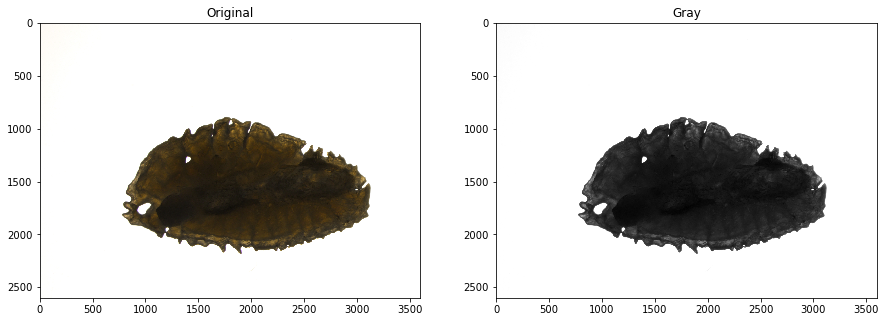

(2600, 3600)

In [2]:
# read image
img = skio.imread('pterois_volitans/left_otolith/124_izq.jpg')
# crop image
img = img[200:2800, 200:3800]
img_gray = rgb2gray(img)
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.title('Original')
plt.imshow(img)
plt.subplot(1,2,2)
plt.title('Gray')
plt.imshow(img_gray, cmap='gray')
plt.show()
img_gray.shape

255.0


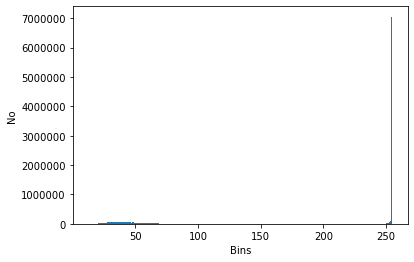

In [3]:
# grayscale histogram
img_gray=img_gray*255
print(np.max(img_gray))
ax = plt.hist(img_gray.ravel(), bins = 256) 
plt.xlabel('Bins')
plt.ylabel('No')
plt.show()

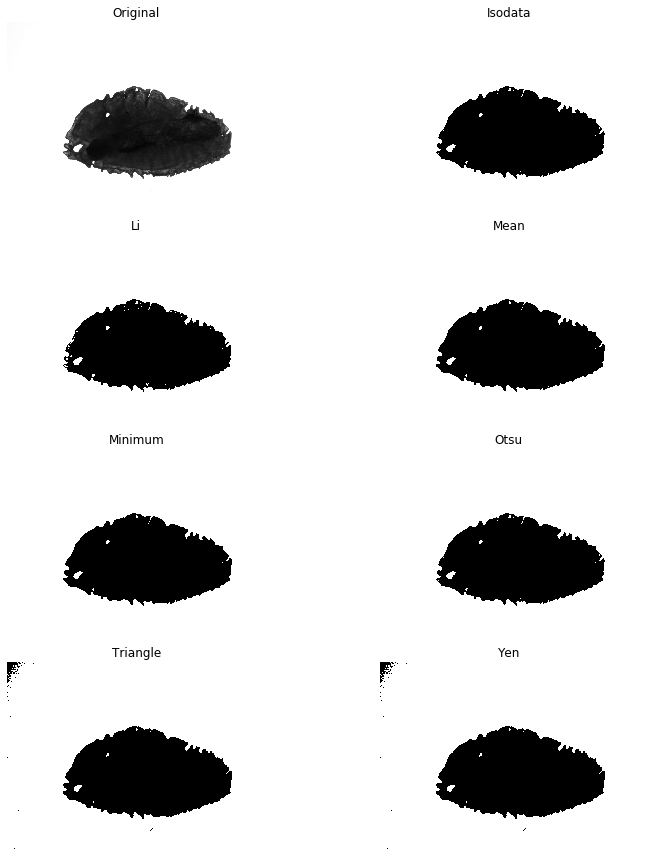

In [4]:
# visual selection of segmentation algorithm
fig, ax=try_all_threshold(img_gray, figsize=(12, 12), verbose=False)
plt.show()

In [5]:
# get segmentation mask
thresh = threshold_mean(img_gray)
im_seg = np.invert(img_gray>thresh)
img_mask = median(im_seg, disk(8))
img_label = label(img_mask)
# get outter contour from mask
edges_img = cv.Canny(np.uint8(img_label*255),10,255)
norm_edges = edges_img/255

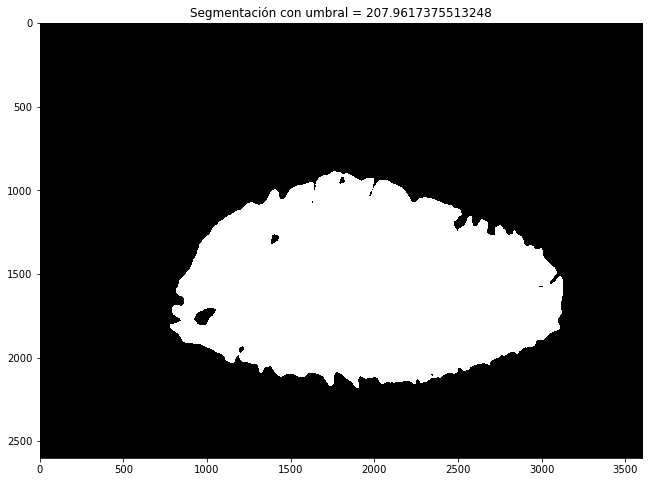

In [6]:
# threeshold segmentation
plt.figure(figsize=(12,8))
plt.title('Segmentación con umbral = '+str(thresh))
plt.imshow(im_seg, cmap='gray')

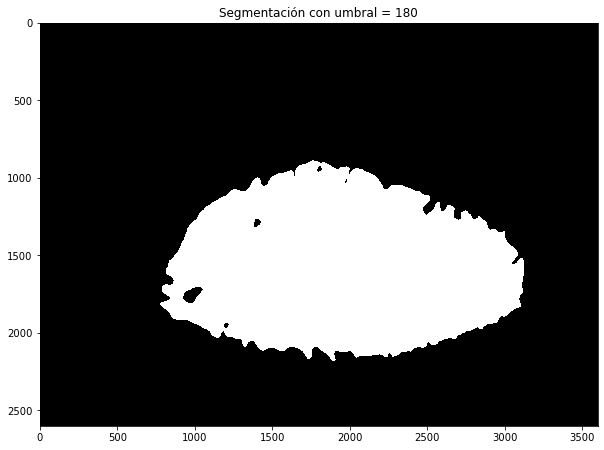

In [7]:
# plot mask
plt.figure(figsize=(10,8))
plt.title('Segmentación con umbral = 180')
plt.imshow(img_mask, cmap='gray')
plt.show()

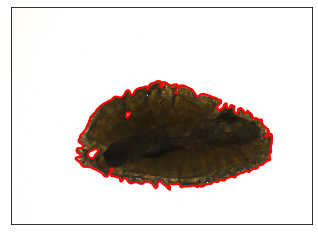

In [8]:
# get outter countour
contours = measure.find_contours(img_mask, 0.8)
fig, ax = plt.subplots()
ax.imshow(img)
for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2, color='red')
ax.axis('Image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

## Select features

Otoliths shape is characterized by the following features
* area
* eccentricity
* perimeter
* euler number
* orientation
* solidity
* area bbox
* area convex
* axis major length
* axis minor length
* firs hu moment (Inertia moment)
* second hu moment
* discrete compactness
* discrete tortuosity

In [9]:
props = regionprops(img_label)

In [10]:
props = regionprops_table(img_label, properties=('area','eccentricity','perimeter',
                                                 'euler_number','orientation','solidity',
                                                 'area_bbox','area_convex','axis_major_length','axis_minor_length'
                                                ))
area = props['area'][0]
pd.DataFrame(props)

,area,eccentricity,perimeter,euler_number,orientation,solidity,area_bbox,area_convex,axis_major_length,axis_minor_length
0,2110873,0.855632,8546.755478,-4,1.531929,0.946448,3043250,2230311,2298.1839,1189.505447


In [11]:
hu_moments = cv.HuMoments(cv.moments(img_gray)).flatten()
print("Hu moments: ",hu_moments)

Hu moments:  [ 9.74565094e-04  9.38122657e-08  6.91919236e-13  4.50831369e-12
 -3.97180017e-24 -6.53672332e-16 -6.90116281e-24]


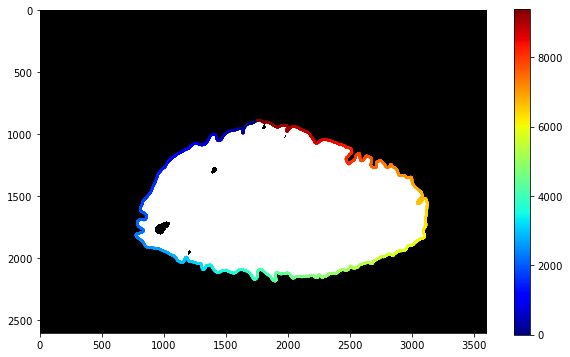

In [12]:
vertex_code,_ = vertexChainCodeWithGraphics(img_label)

In [13]:
print("Code length: ",len(vertex_code))
print("Vertex Chain Code: ",vertex_code)
print("Normalized code chain sum: ",np.sum(vertex_code)/len(vertex_code))

Code length:  9401
Vertex Chain Code:  [3 2 2 ... 2 2 2]
Normalized code chain sum:  1.9996808850122327


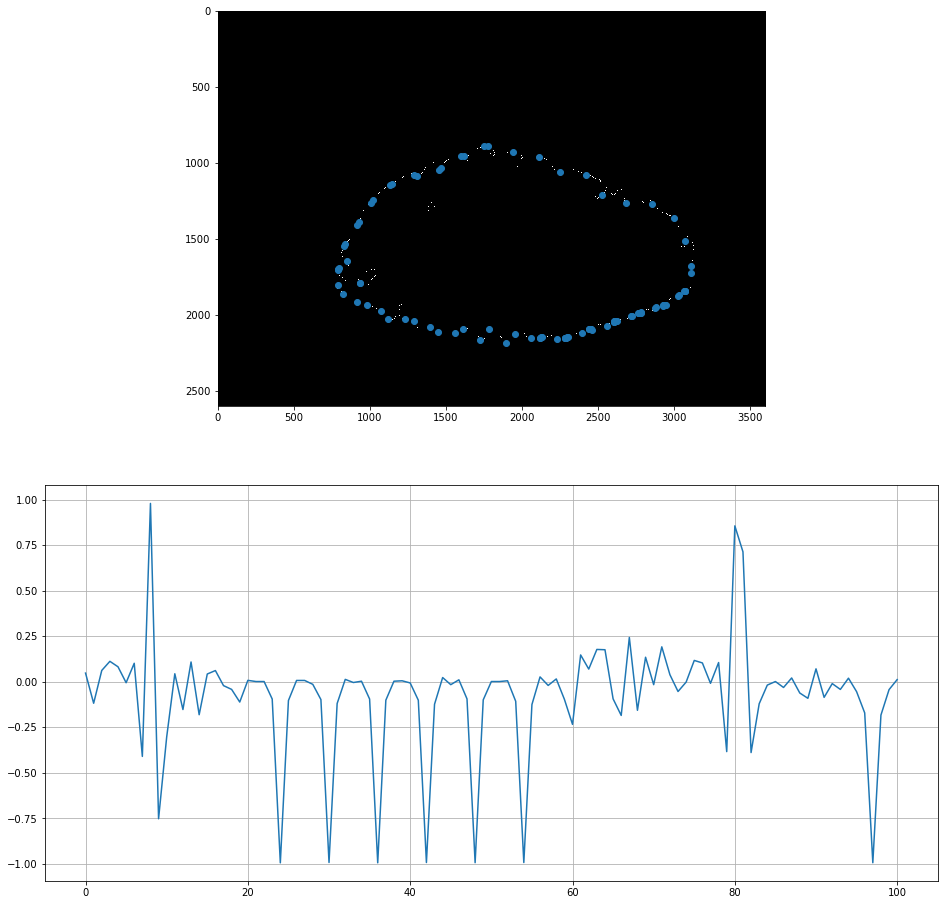

In [14]:
slope_cahin_code = slopeChainCodeWithGraphics(norm_edges,170,100)

In [15]:
discrete_tortuosity = discreteTortuosity(slope_cahin_code)/len(slope_cahin_code)
print("Slope chain code: ",np.array(slope_cahin_code))
print("\nDiscrete tortuosity: ",discrete_tortuosity)

Slope chain code:  [ 0.04809334 -0.11747694  0.06274048  0.11272128  0.08279872 -0.00462452
  0.10204168 -0.40933325  0.97972955 -0.75159076 -0.30222839  0.04446627
 -0.15192856  0.10916268 -0.18041405  0.04307747  0.06205945 -0.02062294
 -0.04143651 -0.11080817  0.00829105  0.00177813  0.00178453 -0.09424564
 -0.99366468 -0.10237181  0.00771791  0.00768853 -0.01361559 -0.09708208
 -0.99184    -0.11885767  0.01361559 -0.00356265  0.00356265 -0.09424564
 -0.99366468 -0.10058096  0.00356265  0.00590531 -0.00590531 -0.10064473
 -0.99199389 -0.12286402  0.0236992  -0.01539133  0.01125881 -0.09343359
 -0.99288368 -0.09875906  0.00178453  0.00177813  0.00590531 -0.10655004
 -0.99214209 -0.12446458  0.02724792 -0.01957703  0.01598308 -0.09577212
 -0.23329604  0.14778662  0.07019875  0.17801891  0.17635819 -0.09324995
 -0.18430876  0.24382378 -0.15612182  0.13521037 -0.01544249  0.1923122
  0.03935159 -0.05294912 -0.00118996  0.11764253  0.10394244 -0.00797068
  0.10612808 -0.38296504  0.85652

In [16]:
# discrete compactness
n_area = np.count_nonzero(img_label)
perimeter = props['perimeter'][0]
discrete_compactness = (n_area-perimeter/4)/(n_area-np.sqrt(n_area))
print("Discrete compactness: ",discrete_compactness)

Discrete compactness:  0.9996758329496495


## Generate dataset

In this sections we extract the mentioned features from whole dataset, and using pandas library then generate the working dataframe for classification task

In [18]:
def featuresDataset(input_img,label_tag,threeshold=180):    
    # read image
    img = skio.imread(input_img)
    # crop image
    img = img[200:2800, 200:3800]
    img_gray = rgb2gray(img)
    img_gray=img_gray*255
    # get segmentation mask
    thresh = threshold_mean(img_gray)
    im_seg = np.invert(img_gray>thresh)
    img_mask = median(im_seg, disk(8))
    img_label = label(img_mask)
    # get outter contour from mask
    edges_img = cv.Canny(np.uint8(img_mask*255),10,255)
    norm_edges = edges_img/255
    # basic shape features
    props = regionprops_table(img_label, properties=('area','eccentricity','perimeter',
                                                 'euler_number','orientation','solidity',
                                                 'area_bbox','area_convex','axis_major_length','axis_minor_length'
                                                ))
    area = np.max(props['area'])
    eccentricity = np.max(props['eccentricity'])
    perimeter = np.max(props['perimeter'])
    euler_number = np.mean(props['euler_number'])
    orientation = np.max(props['orientation'])
    solidity = np.max(props['solidity'])
    area_bbox = np.max(props['area_bbox'])
    area_convex = np.max(props['area_convex'])
    axis_major_length = np.max(props['axis_major_length'])
    axis_minor_length = np.max(props['axis_minor_length'])    
    pd.DataFrame(props)
    # advanced features
    n_area = np.count_nonzero(img_label)
    hu_moments = cv.HuMoments(cv.moments(img_gray)).flatten()
    firs_hu_moment = hu_moments[0]
    second_hu_moment = hu_moments[1]
    #vertex_code,_ = vertexChainCode(img_label)
    #vcc_sum = np.sum(vertex_code)/len(vertex_code)
    #slope_cahin_code = slopeChainCode(norm_edges,220,200)
    slope_chain_code = slopeChainCodeUnitRadio(img_label)
    # discrete tortuosity
    discrete_tortuosity = discreteTortuosity(slope_chain_code)/len(slope_chain_code) if len(slope_chain_code)>0 else 0
    # discrete compactness
    discrete_compactness = (n_area-perimeter/4)/(n_area-np.sqrt(n_area))
    # return image features
    return np.array([
        area,
        eccentricity,
        perimeter,
        euler_number,
        orientation,
        solidity,
        area_bbox,
        area_convex,
        axis_major_length,
        axis_minor_length,
        firs_hu_moment,
        second_hu_moment,
        discrete_compactness,
        discrete_tortuosity,
        label_tag
    ]);

In [19]:
# extract features from dataset
data = np.empty((0,15),np.float128)
otolith_path = "pterois_volitans/left_otolith/"
directory = os.fsencode(otolith_path)    
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith(".jpg"): 
        img_path = os.path.join(otolith_path, filename)
        features_data = featuresDataset(img_path,1)
        data = np.append(data, np.array([features_data]),axis=0)
otolith_path = "pterois_volitans/right_otolith/"
directory = os.fsencode(otolith_path)    
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith(".jpg"): 
        img_path = os.path.join(otolith_path, filename)
        features_data = featuresDataset(img_path,0)
        data = np.append(data, np.array([features_data]),axis=0)

In [20]:
columns_head = np.array(['area','eccentricity','perimeter','euler_number','orientation',
                         'solidity','area_bbox','area_convex','axis_major_length','axis_minor_length',
                         'firs_hu_moment','second_hu_moment','discrete_compactness','discrete_tortuosity','label'
                        ]).T
data_set = pd.DataFrame(data=data,columns=columns_head)
data_set.head()

,area,eccentricity,perimeter,euler_number,orientation,solidity,area_bbox,area_convex,axis_major_length,axis_minor_length,firs_hu_moment,second_hu_moment,discrete_compactness,discrete_tortuosity,label
0,2110873.0,0.855632,8546.755478,-4.0,1.531929,0.946448,3043250.0,2230311.0,2298.183900,1189.505447,0.000975,9.381227e-08,0.999676,0.524508,1.0
1,1650691.0,0.897473,7212.016229,1.0,1.553258,0.945664,2396025.0,1745536.0,2214.632684,976.805938,0.000871,7.001974e-08,0.999686,0.519882,1.0
2,1345506.0,0.860483,5808.860674,0.0,1.457399,0.939517,2000226.0,1432125.0,1854.071838,944.612238,0.000812,6.464548e-08,0.999783,0.521973,1.0
3,1801955.0,0.871744,8158.741192,-4.0,-1.562945,0.932771,2709342.0,1931829.0,2188.407314,1072.234096,0.000840,6.717923e-08,0.999613,0.527417,1.0
4,2096541.0,0.881172,12052.716298,-19.0,1.493252,0.907903,3232087.0,2309212.0,2411.264701,1140.037488,0.000912,7.473273e-08,0.999253,0.530954,1.0


In [21]:
# save dataset in file in order to use it later
data_set.to_csv('otoliths_dateset.csv')

## Read dataset

The next fourth algorithms are trained to fit otoliths dataset. These are compared under accuracy, AUCROC and recall parameters.
* Random forest classifier
* Multilayer perceptron classifier
* Support vector machine classifier
* Logistic regression classifier

In [2]:
data_set = pd.read_csv('otoliths_dateset.csv')
n = len(data_set)
data_set.head()

,Unnamed: 0,area,eccentricity,perimeter,euler_number,orientation,solidity,area_bbox,area_convex,axis_major_length,axis_minor_length,firs_hu_moment,second_hu_moment,discrete_compactness,discrete_tortuosity,label
0,0,2110873.0,0.855632,8546.755478,-4.0,1.531929,0.946448,3043250.0,2230311.0,2298.183900,1189.505447,0.000975,9.381227e-08,0.999676,0.524508,1.0
1,1,1650691.0,0.897473,7212.016229,1.0,1.553258,0.945664,2396025.0,1745536.0,2214.632684,976.805938,0.000871,7.001974e-08,0.999686,0.519882,1.0
2,2,1345506.0,0.860483,5808.860674,0.0,1.457399,0.939517,2000226.0,1432125.0,1854.071838,944.612238,0.000812,6.464548e-08,0.999783,0.521973,1.0
3,3,1801955.0,0.871744,8158.741192,-4.0,-1.562945,0.932771,2709342.0,1931829.0,2188.407314,1072.234096,0.000840,6.717923e-08,0.999613,0.527417,1.0
4,4,2096541.0,0.881172,12052.716298,-19.0,1.493252,0.907903,3232087.0,2309212.0,2411.264701,1140.037488,0.000912,7.473273e-08,0.999253,0.530954,1.0


In [3]:
# separate independent variables
X = data_set.iloc[:,1:-1]
# output label (1:left, 0:right)
y = data_set.values[:,-1]
# features names
names = data_set.columns[1:-1]

## Data analysis

In [4]:
# statistic information from data
X.describe()

,area,eccentricity,perimeter,euler_number,orientation,solidity,area_bbox,area_convex,axis_major_length,axis_minor_length,firs_hu_moment,second_hu_moment,discrete_compactness,discrete_tortuosity
count,2.080000e+02,208.000000,208.000000,208.000000,208.000000,208.000000,2.080000e+02,2.080000e+02,208.000000,208.000000,208.000000,2.080000e+02,208.000000,208.000000
mean,1.819202e+06,0.871939,9813.686333,-14.239797,0.017558,0.930351,2.775175e+06,1.989923e+06,2189.342444,1085.858679,0.000850,6.968981e-08,0.999417,0.528661
std,4.602563e+05,0.032733,3458.309344,17.164275,1.466155,0.031396,7.536187e+05,5.340555e+05,294.969413,159.390596,0.000067,1.068148e-08,0.000326,0.037154
min,7.502970e+05,0.782267,4089.413706,-114.000000,-1.570613,0.838113,1.078896e+06,7.892940e+05,1404.790251,692.766555,0.000731,5.291012e-08,0.998010,0.453985
25%,1.470540e+06,0.857038,7378.046406,-17.250000,-1.500375,0.913357,2.178285e+06,1.579964e+06,2011.705511,975.485975,0.000800,6.216388e-08,0.999316,0.519081
50%,1.856388e+06,0.870149,9174.367653,-9.000000,0.480556,0.933094,2.824113e+06,2.034738e+06,2224.736136,1101.319260,0.000829,6.609621e-08,0.999511,0.522664
75%,2.111864e+06,0.884458,11809.649235,-3.750000,1.507360,0.945067,3.297478e+06,2.356509e+06,2380.811831,1198.756266,0.000896,7.522235e-08,0.999643,0.527303
max,2.883057e+06,1.000000,20884.868745,1.000000,1.570796,1.000000,4.554090e+06,3.231714e+06,2830.520286,1473.615722,0.001067,1.154488e-07,0.999834,0.859496


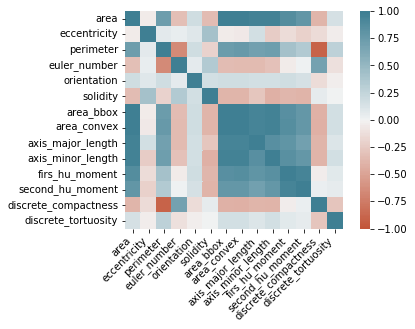

In [5]:
# plot features correlation
#f = plt.figure(figsize=(12, 12))
#plt.matshow(X.corr(),fignum=f.number)
#cb = plt.colorbar()
#cb.ax.tick_params(labelsize=12)
#plt.title('Correlation Matrix', );
ax = sns.heatmap(X.corr(), vmin=-1, vmax=1, center=0,
                 cmap=sns.diverging_palette(20, 220, n=200),square=True)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45,horizontalalignment='right');

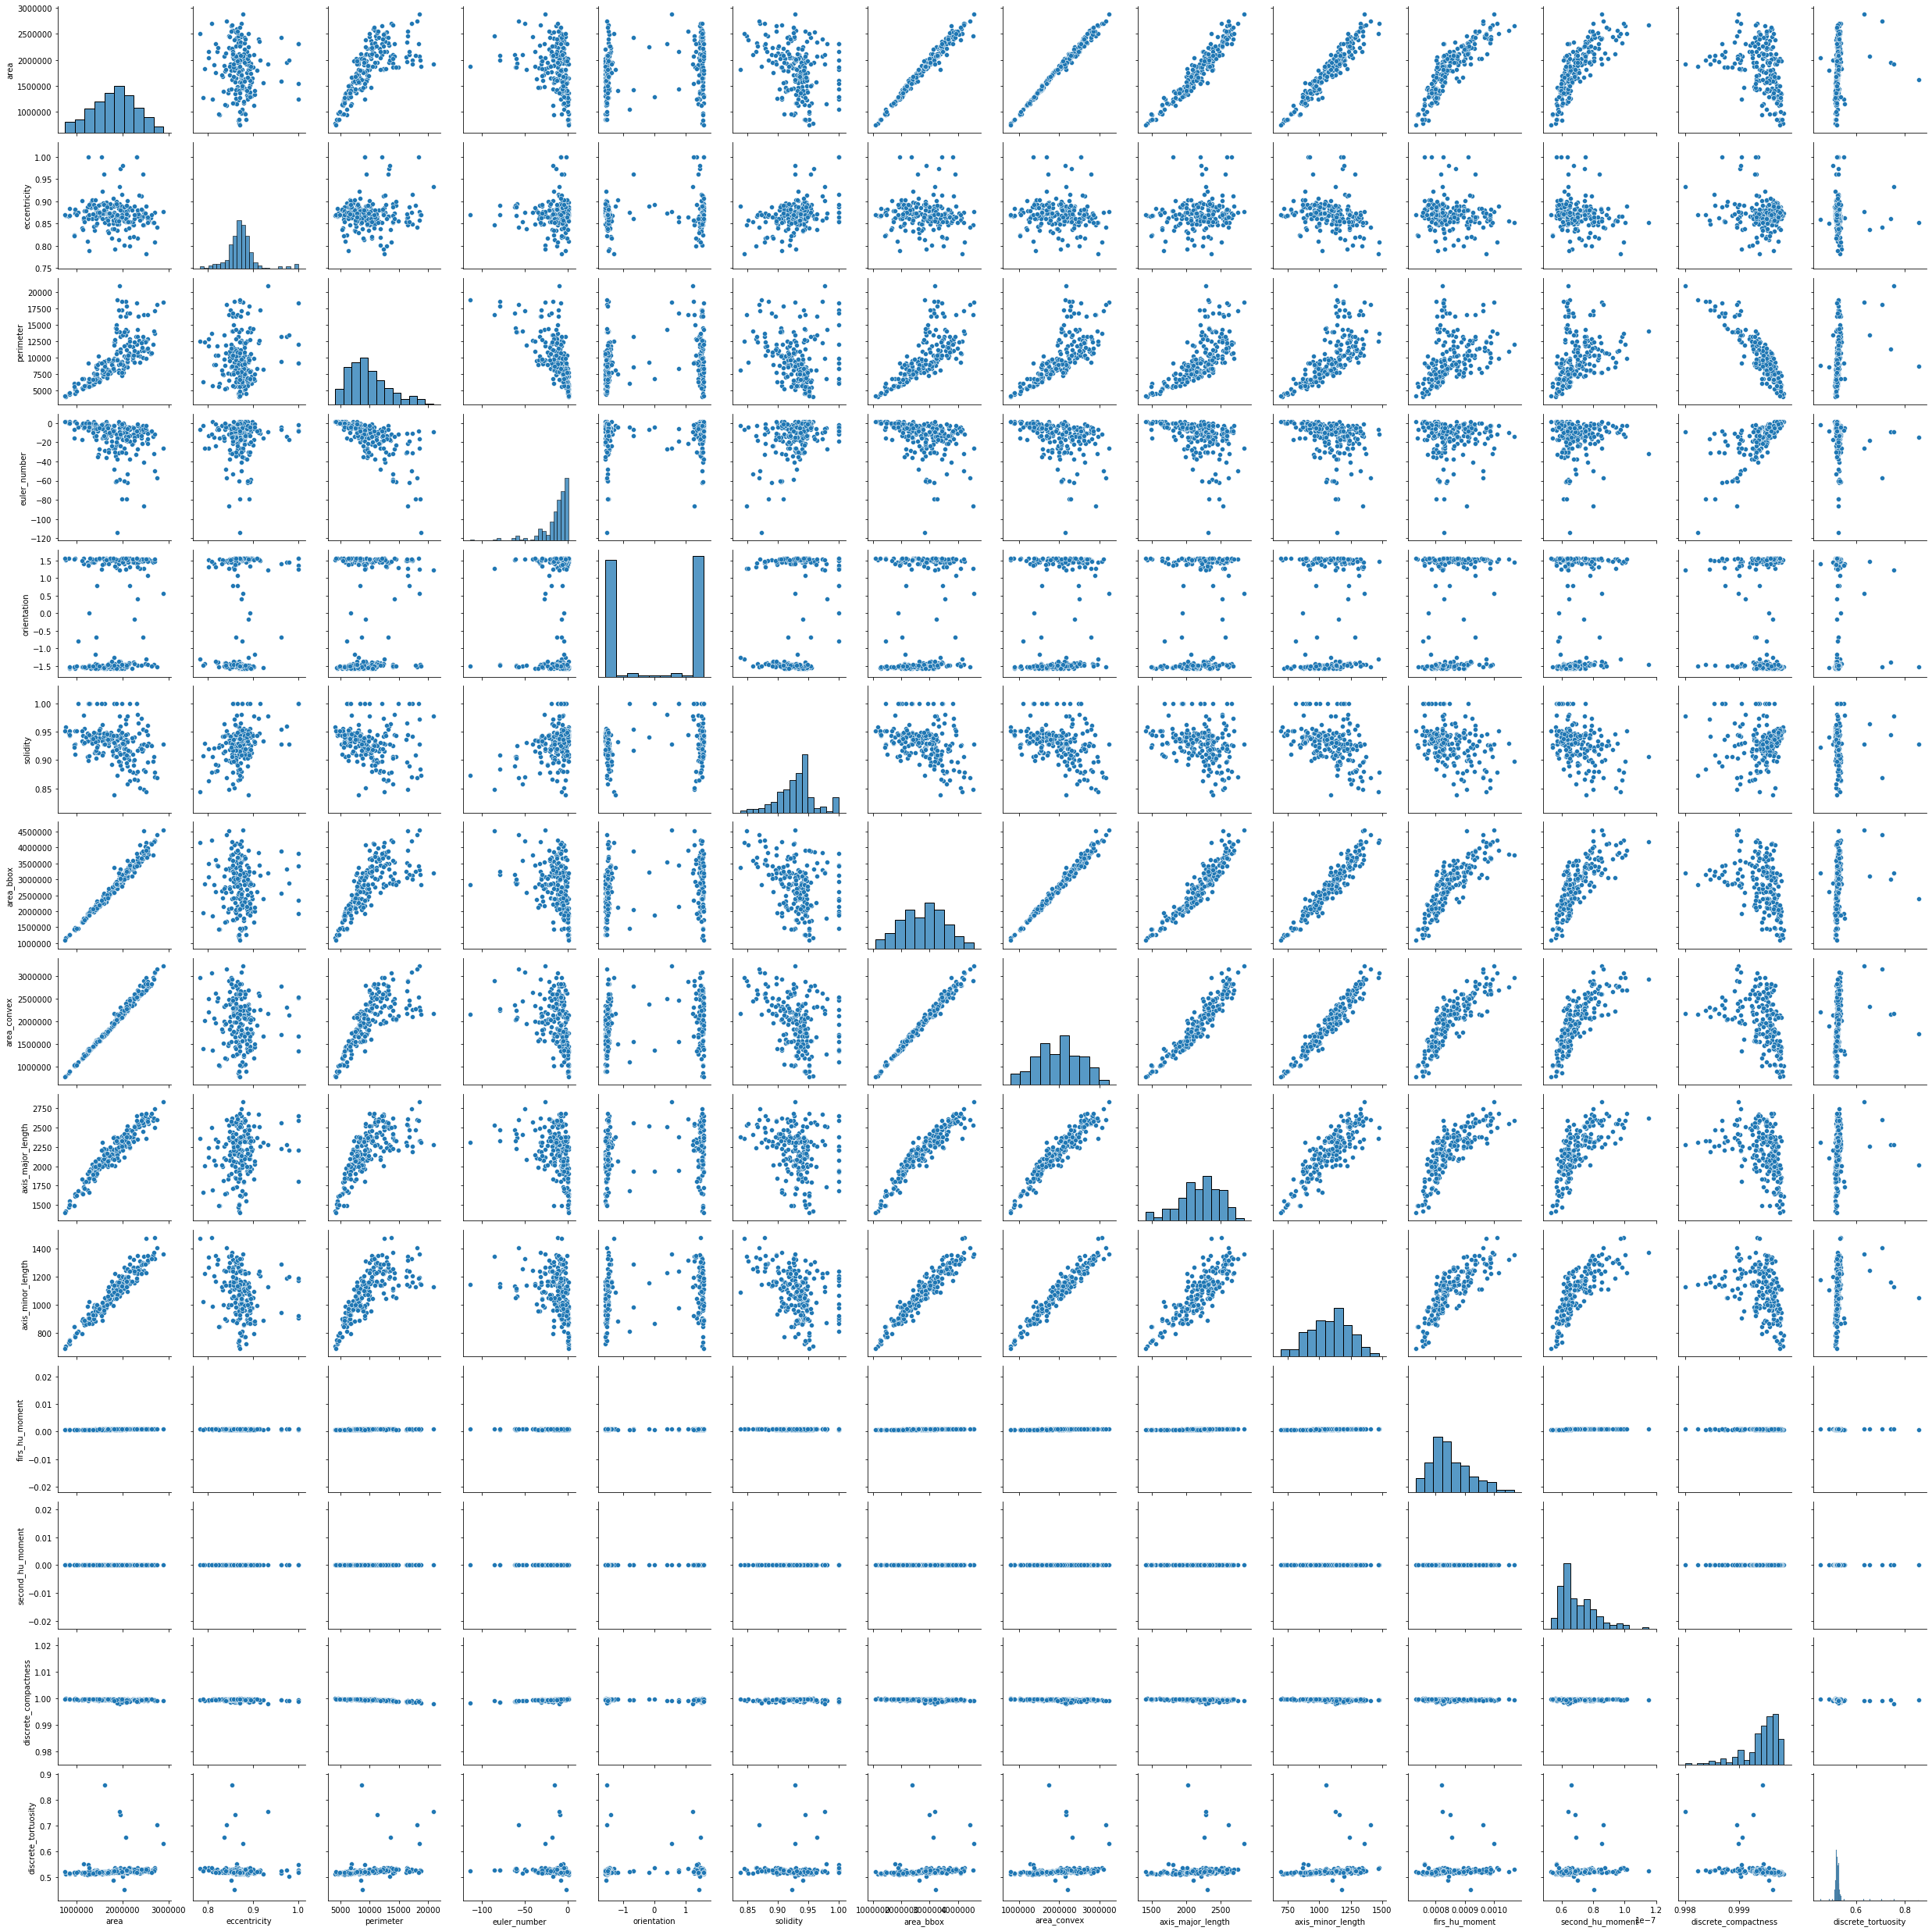

In [6]:
sns.pairplot(X)

## Split training and validation subset

In [7]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=50)
print("Train size: ",len(X_train))
print("Test size: ",len(X_test))

Train size:  166
Test size:  42


## Train classification models

In [8]:
# random forest model
clf_rfc =RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=1)
clf_rfc.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=1)

In [12]:
# multilayer perceptron model
clf_mlp = MLPClassifier(activation='relu', hidden_layer_sizes=140,max_iter=1200,solver='adam',random_state=1)
clf_mlp.fit(X_train.values, y_train)

MLPClassifier(hidden_layer_sizes=140, max_iter=1200, random_state=1)

In [10]:
# support vector machine model
clf_svc =SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=1)
clf_svc.fit(X_train, y_train)

SVC(class_weight='balanced', probability=True, random_state=1)

In [11]:
# logistic regression model
log_reg = LogisticRegression()
log_reg.fit(X_train,y_train)

LogisticRegression()

## Make predictions on test set

In [13]:
# random forest classifier
rfc_prediction = clf_rfc.predict(X_test)
# random forest classifier
mlp_prediction = clf_mlp.predict(X_test.values)
# random forest classifier
svc_prediction = clf_svc.predict(X_test)
# random forest classifier
reg_prediction = log_reg.predict(X_test)

## Evaluate classification models

In [14]:
def validationResult(model,model_name,y_test,y_pred):
    # generate confussion matrix for each model
    cnf_matrix = confusion_matrix(y_test,y_pred)
    # plot confussion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix,display_labels=model.classes_)
    disp.plot()
    plt.title('Validation')
    plt.show()
    # validation results for random forest model
    print(model_name)
    print("Sklearn Accuracy: ",metrics.accuracy_score(y_test, y_pred)*100," %")
    print("Sklearn Precision: ",metrics.precision_score(y_test, y_pred)*100," %")
    print("Sklearn Recall: ",metrics.recall_score(y_test, y_pred)*100," %")
    # paremters from confusion matrix
    tp = cnf_matrix[1,1]
    tn = cnf_matrix[0,0]
    fp = cnf_matrix[0,1]
    fn = cnf_matrix[1,0]
    # sensibilidad
    tpr = tp/(tp+fn)
    print("Sensitivity - Recall (true positive rate): ",tpr)
    # sensibilidad
    spc = tn/(tn+fp)
    print("Specificity: ",spc)
    # accuracy
    acc = (tp+tn)/(fp+fn+tp+tn)
    print("Accuracy: ",acc)
    # precision
    pre = tp/(tp+fp)
    print("Precision: ",pre)
    # f1-score
    f1 = 2*pre*tpr/(pre+tpr)
    print("F1-Score: ",f1)
    # false positive rate
    fpr = fp/(fp+tn)
    print("False positive rate: ",fpr)
    # error
    err = (fp+fn)/(fp+fn+tp+tn)
    print("Error: ",err)
    target_names = ['Right otolith', 'Left otolith']
    print(classification_report(y_test, y_pred, target_names=target_names))

In [15]:
# AUROC validation
def ROCValidation(model,X,y):
    stratKFold = StratifiedKFold(n_splits=6)
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    fig, ax = plt.subplots()
    for i, (train, test) in enumerate(stratKFold.split(X, y)):
        model.fit(X.values[train], y[train])
        viz = RocCurveDisplay.from_estimator(
            model,
            X.values[test],
            y[test],
            name="ROC fold {}".format(i),
            alpha=0.3,
            lw=1,
            ax=ax,
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )
    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        title="Receiver operating characteristic example",
    )
    ax.legend(loc="lower right")
    plt.show()

In [16]:
# randome forest ACC
scores = cross_val_score(clf_rfc, X_train, y_train, cv=5)
scores=scores*100
print("Random forest ACC (Media/STD)")
print("%0.1f+/-%0.1f \n" % (scores.mean(), scores.std()))
# multilayer perceptron ACC
scores = cross_val_score(clf_mlp, X_train.values, y_train, cv=5)
scores=scores*100
print("Multilayer perceptron ACC (Media/STD)")
print("%0.1f+/-%0.1f \n" % (scores.mean(), scores.std()))
# support vector machine ACC
scores = cross_val_score(clf_svc, X_train, y_train, cv=5)
scores=scores*100
print("Support vector machine ACC (Media/STD)")
print("%0.1f+/-%0.1f \n" % (scores.mean(), scores.std()))
# logistic regression ACC
scores = cross_val_score(log_reg, X_train, y_train, cv=5)
scores=scores*100
print("Logistic regression ACC (Media/STD)")
print("%0.1f+/-%0.1f \n" % (scores.mean(), scores.std()))

Random forest ACC (Media/STD)
80.8+/-6.3 

Multilayer perceptron ACC (Media/STD)
46.4+/-5.6 

Support vector machine ACC (Media/STD)
44.6+/-3.7 

Logistic regression ACC (Media/STD)
55.4+/-2.3 



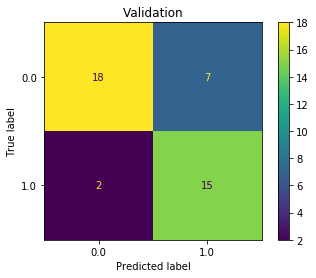

RANDOM FOREST
Sklearn Accuracy:  78.57142857142857  %
Sklearn Precision:  68.18181818181817  %
Sklearn Recall:  88.23529411764706  %
Sensitivity - Recall (true positive rate):  0.8823529411764706
Specificity:  0.72
Accuracy:  0.7857142857142857
Precision:  0.6818181818181818
F1-Score:  0.7692307692307693
False positive rate:  0.28
Error:  0.21428571428571427
               precision    recall  f1-score   support

Right otolith       0.90      0.72      0.80        25
 Left otolith       0.68      0.88      0.77        17

     accuracy                           0.79        42
    macro avg       0.79      0.80      0.78        42
 weighted avg       0.81      0.79      0.79        42



In [17]:
# random forest validation
validationResult(clf_rfc,"RANDOM FOREST",y_test,rfc_prediction)

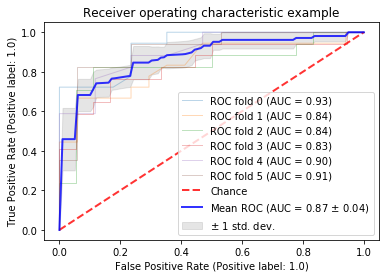

In [18]:
ROCValidation(clf_rfc,X,y)

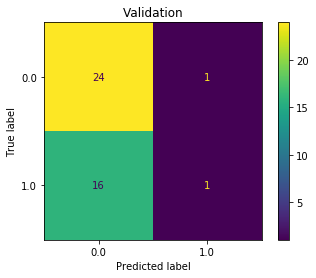

MULTILAYER PERCEPTRON
Sklearn Accuracy:  59.523809523809526  %
Sklearn Precision:  50.0  %
Sklearn Recall:  5.88235294117647  %
Sensitivity - Recall (true positive rate):  0.058823529411764705
Specificity:  0.96
Accuracy:  0.5952380952380952
Precision:  0.5
F1-Score:  0.10526315789473684
False positive rate:  0.04
Error:  0.40476190476190477
               precision    recall  f1-score   support

Right otolith       0.60      0.96      0.74        25
 Left otolith       0.50      0.06      0.11        17

     accuracy                           0.60        42
    macro avg       0.55      0.51      0.42        42
 weighted avg       0.56      0.60      0.48        42



In [19]:
# multilayer perceptron results
validationResult(clf_mlp,"MULTILAYER PERCEPTRON",y_test,mlp_prediction)

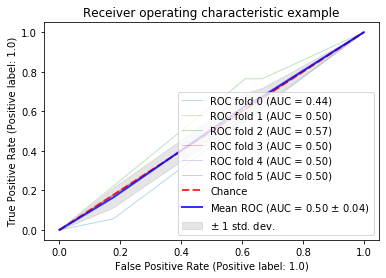

In [20]:
ROCValidation(clf_mlp,X,y)

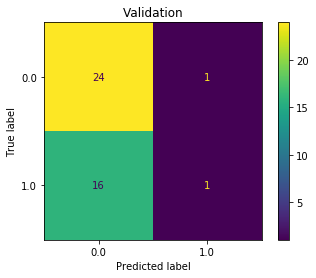

SUPPORT VECTOR MACHINE
Sklearn Accuracy:  59.523809523809526  %
Sklearn Precision:  50.0  %
Sklearn Recall:  5.88235294117647  %
Sensitivity - Recall (true positive rate):  0.058823529411764705
Specificity:  0.96
Accuracy:  0.5952380952380952
Precision:  0.5
F1-Score:  0.10526315789473684
False positive rate:  0.04
Error:  0.40476190476190477
               precision    recall  f1-score   support

Right otolith       0.60      0.96      0.74        25
 Left otolith       0.50      0.06      0.11        17

     accuracy                           0.60        42
    macro avg       0.55      0.51      0.42        42
 weighted avg       0.56      0.60      0.48        42



In [21]:
# support vector machine results
validationResult(clf_svc,"SUPPORT VECTOR MACHINE",y_test,svc_prediction)

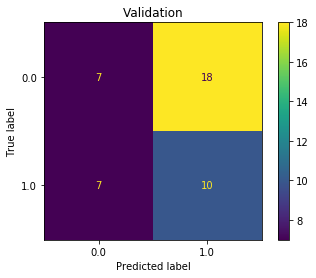

LOGISTIC REGRESSION
Sklearn Accuracy:  40.476190476190474  %
Sklearn Precision:  35.714285714285715  %
Sklearn Recall:  58.82352941176471  %
Sensitivity - Recall (true positive rate):  0.5882352941176471
Specificity:  0.28
Accuracy:  0.40476190476190477
Precision:  0.35714285714285715
F1-Score:  0.4444444444444445
False positive rate:  0.72
Error:  0.5952380952380952
               precision    recall  f1-score   support

Right otolith       0.50      0.28      0.36        25
 Left otolith       0.36      0.59      0.44        17

     accuracy                           0.40        42
    macro avg       0.43      0.43      0.40        42
 weighted avg       0.44      0.40      0.39        42



In [22]:
# logistic regression results
validationResult(log_reg,"LOGISTIC REGRESSION",y_test,reg_prediction)

In [23]:
# prediction class probability with random forest
Y_predn=rfc_prediction[:,np.newaxis]
Y_testn=y_test[:,np.newaxis]
Y_proba=clf_rfc.predict_proba(X_test)
Y_proba_clase1=(Y_proba[:,0])*100
Y_proba_clase2=(Y_proba[:,1])*100
Y_proban_clase1=Y_proba_clase1[:,np.newaxis]
Y_proban_clase2=Y_proba_clase2[:,np.newaxis]
resultados=np.concatenate([Y_predn, Y_testn,Y_proban_clase1,Y_proban_clase2], axis = 1)
resul = pd.DataFrame(resultados, columns=["Prediction", "Real","Left otolith probability","Right otolith probability"])
resul

/home/bandala/.local/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


,Prediction,Real,Left otolith probability,Right otolith probability
0,1.0,0.0,70.0,30.0
1,1.0,1.0,19.0,81.0
2,1.0,1.0,6.0,94.0
3,1.0,1.0,17.0,83.0
4,0.0,0.0,75.0,25.0
5,1.0,1.0,8.0,92.0
6,0.0,0.0,73.0,27.0
7,1.0,1.0,9.0,91.0
8,0.0,0.0,89.0,11.0
9,0.0,0.0,90.0,10.0


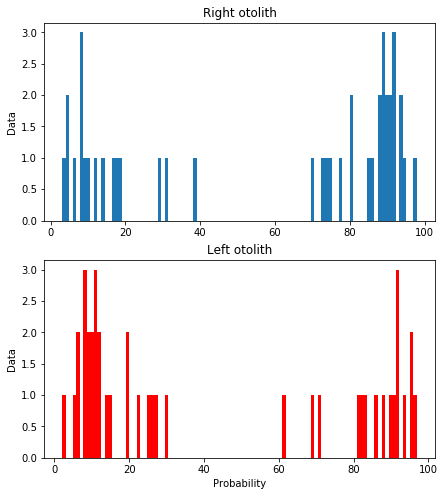

In [24]:
# random forest prediction probability
plt.figure(figsize=(7,8))
plt.subplot(2,1,1)
plt.hist(Y_proban_clase1, bins = 100),plt.ylabel('Data'),plt.title('Right otolith')
plt.subplot(2,1,2)
plt.hist(Y_proban_clase2, bins = 100, color='red'), plt.xlabel('Probability'),plt.ylabel('Data'),plt.title('Left otolith')
plt.show()

In [25]:
# prediction class probability with multilayer perceptron
Y_predn=mlp_prediction[:,np.newaxis]
Y_testn=y_test[:,np.newaxis]
Y_proba=clf_mlp.predict_proba(X_test)
Y_proba_clase1=(Y_proba[:,0])*100
Y_proba_clase2=(Y_proba[:,1])*100
Y_proban_clase1=Y_proba_clase1[:,np.newaxis]
Y_proban_clase2=Y_proba_clase2[:,np.newaxis]
resultados=np.concatenate([Y_predn, Y_testn,Y_proban_clase1,Y_proban_clase2], axis = 1)
resul = pd.DataFrame(resultados, columns=["Prediction", "Real","Left otolith probability","Right otolith probability"])
resul

/home/bandala/.local/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


,Prediction,Real,Left otolith probability,Right otolith probability
0,0.0,0.0,0.0,100.0
1,1.0,1.0,0.0,100.0
2,0.0,1.0,0.0,100.0
3,0.0,1.0,0.0,100.0
4,0.0,0.0,0.0,100.0
5,0.0,1.0,0.0,100.0
6,0.0,0.0,0.0,100.0
7,0.0,1.0,0.0,100.0
8,0.0,0.0,0.0,100.0
9,0.0,0.0,0.0,100.0


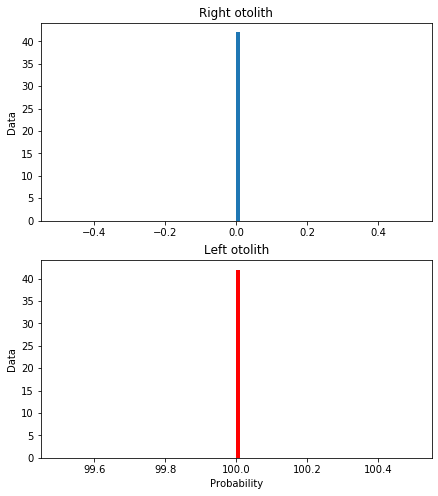

In [26]:
# multilayer perceptron prediction probability
plt.figure(figsize=(7,8))
plt.subplot(2,1,1)
plt.hist(Y_proban_clase1, bins = 100),plt.ylabel('Data'),plt.title('Right otolith')
plt.subplot(2,1,2)
plt.hist(Y_proban_clase2, bins = 100, color='red'), plt.xlabel('Probability'),plt.ylabel('Data'),plt.title('Left otolith')
plt.show()

## Learning curve

In [27]:
# random forest model learning curve
train_sizes,train_scores,test_scores = learning_curve(RandomForestClassifier(),X,y,cv=10,scoring='accuracy',n_jobs=1,train_sizes=np.linspace(0.01,1,60))

In [28]:
# statistic results
train_mean = np.mean(train_scores,axis=1)
train_std = np.std(train_scores,axis=1)
test_mean = np.mean(test_scores,axis=1)
test_std = np.std(test_scores,axis=1)

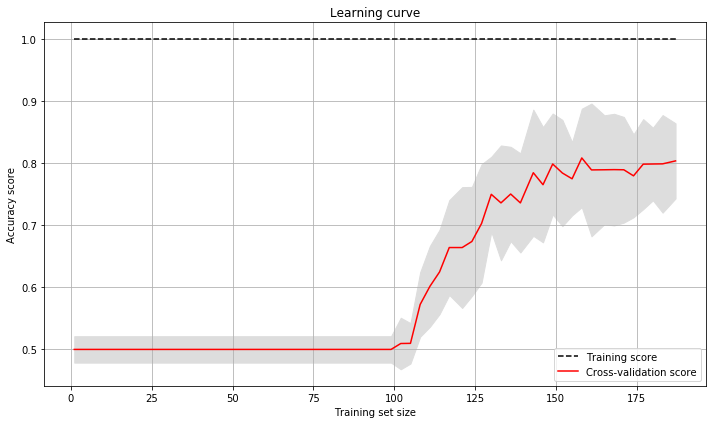

In [29]:
plt.subplots(1,figsize=(10,6))
# draw lines
plt.plot(train_sizes,train_mean,"--",color="black",label="Training score")
plt.plot(train_sizes,test_mean,color="red",label="Cross-validation score")
# draw bands
plt.fill_between(train_sizes,train_mean-train_std,train_mean+train_std,color="#DDDDDD")
plt.fill_between(train_sizes,test_mean-test_std,test_mean+test_std,color="#DDDDDD")
# create plot
plt.title("Learning curve")
plt.xlabel("Training set size")
plt.ylabel("Accuracy score")
plt.legend(loc="best")
plt.tight_layout()
plt.grid()

In [30]:
# random forest model learning curve
train_sizes,train_scores,test_scores = learning_curve(MLPClassifier(),X,y,cv=10,scoring='accuracy',n_jobs=1,train_sizes=np.linspace(0.01,1,60))

In [31]:
# statistic results
train_mean = np.mean(train_scores,axis=1)
train_std = np.std(train_scores,axis=1)
test_mean = np.mean(test_scores,axis=1)
test_std = np.std(test_scores,axis=1)

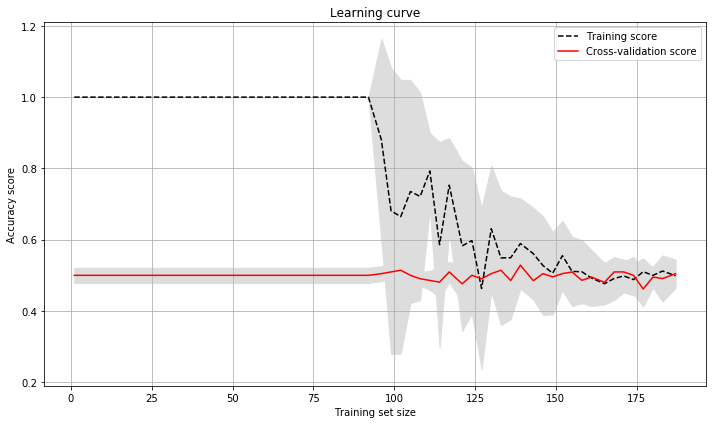

In [32]:
plt.subplots(1,figsize=(10,6))
# draw lines
plt.plot(train_sizes,train_mean,"--",color="black",label="Training score")
plt.plot(train_sizes,test_mean,color="red",label="Cross-validation score")
# draw bands
plt.fill_between(train_sizes,train_mean-train_std,train_mean+train_std,color="#DDDDDD")
plt.fill_between(train_sizes,test_mean-test_std,test_mean+test_std,color="#DDDDDD")
# create plot
plt.title("Learning curve")
plt.xlabel("Training set size")
plt.ylabel("Accuracy score")
plt.legend(loc="best")
plt.tight_layout()
plt.grid()

## Features selection using Mean Decrease in Impurity

[0.04312569 0.06108348 0.0486368  0.03738058 0.39027308 0.06439593
 0.04096135 0.04720218 0.04611798 0.05122629 0.04715888 0.
 0.05567698 0.06676079]
1. feature 4 (0.390273)
2. feature 13 (0.066761)
3. feature 5 (0.064396)
4. feature 1 (0.061083)
5. feature 12 (0.055677)
6. feature 9 (0.051226)
7. feature 2 (0.048637)
8. feature 7 (0.047202)
9. feature 10 (0.047159)
10. feature 8 (0.046118)
11. feature 0 (0.043126)
12. feature 6 (0.040961)
13. feature 3 (0.037381)
14. feature 11 (0.000000)


<Figure size 720x576 with 0 Axes>

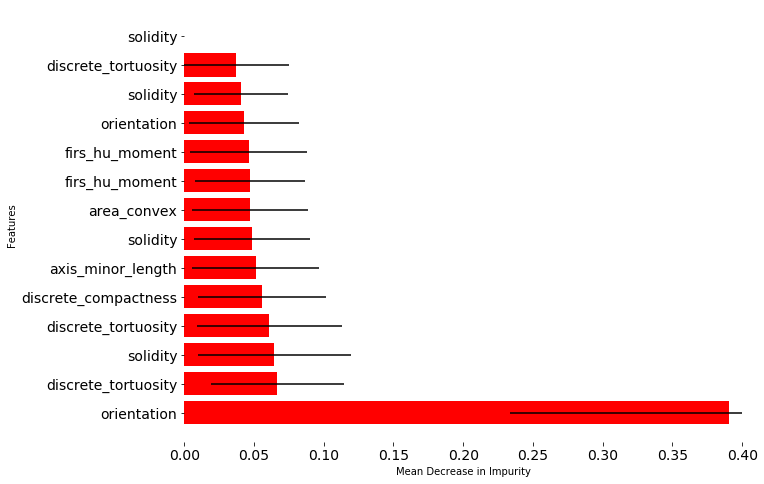

In [33]:
importances = clf_rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_rfc.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
print(importances)
plt.figure(figsize=(10, 8))
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)
caract=list(names)
for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    caract[f]=caract[indices[f]]
indices=np.transpose(indices)

#Plot the feature importances of the fores
plt.figure(figsize=(10, 8))
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 
#plt.title("Contribución de las Variables")
plt.ylabel("Features")
plt.xlabel("Mean Decrease in Impurity")
a=14
plt.barh(range(a), importances[indices[0:a]],
        color="r", xerr=std[indices[0:a]], align="center")
plt.yticks(range(a), caract[0:a])
plt.box(False)


plt.ylim([-1, a])
plt.xlim([0, 0.40])
plt.show()

## Training and validating models with features selection

In [34]:
# select data
feature_cols = ['orientation','solidity','axis_major_length','axis_minor_length',
                'firs_hu_moment','discrete_compactness','discrete_tortuosity']
X_sel = X[feature_cols] # Features
# split training and validations
X_train,X_test,y_train,y_test = train_test_split(X_sel,y,test_size=0.2,random_state=50)

In [36]:
# random forest model
clf_rfc =RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=1)
clf_rfc.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=1)

In [37]:
# multilayer perceptron model
clf_mlp = MLPClassifier(activation='relu', hidden_layer_sizes=140,max_iter=1200,solver='adam',random_state=1)
clf_mlp.fit(X_train.values, y_train)

MLPClassifier(hidden_layer_sizes=140, max_iter=1200, random_state=1)

In [38]:
# random forest classifier predictions
rfc_prediction = clf_rfc.predict(X_test)
# random forest classifier predictions
mlp_prediction = clf_mlp.predict(X_test.values)

In [39]:
# randome forest ACC
scores = cross_val_score(clf_rfc, X_train, y_train, cv=5)
scores=scores*100
print("Random forest ACC (Media/STD)")
print("%0.1f+/-%0.1f \n" % (scores.mean(), scores.std()))
# multilayer perceptron ACC
scores = cross_val_score(clf_mlp, X_train, y_train, cv=5)
scores=scores*100
print("Multilayer perceptron ACC (Media/STD)")
print("%0.1f+/-%0.1f \n" % (scores.mean(), scores.std()))

Random forest ACC (Media/STD)
81.4+/-4.7 

Multilayer perceptron ACC (Media/STD)
80.1+/-4.2 



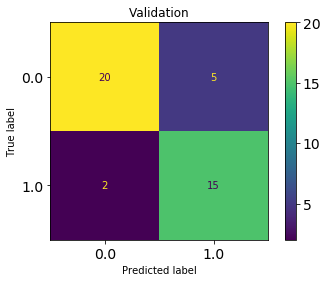

RANDOM FOREST
Sklearn Accuracy:  83.33333333333334  %
Sklearn Precision:  75.0  %
Sklearn Recall:  88.23529411764706  %
Sensitivity - Recall (true positive rate):  0.8823529411764706
Specificity:  0.8
Accuracy:  0.8333333333333334
Precision:  0.75
F1-Score:  0.8108108108108107
False positive rate:  0.2
Error:  0.16666666666666666
               precision    recall  f1-score   support

Right otolith       0.91      0.80      0.85        25
 Left otolith       0.75      0.88      0.81        17

     accuracy                           0.83        42
    macro avg       0.83      0.84      0.83        42
 weighted avg       0.84      0.83      0.83        42



In [40]:
# random forest validation
validationResult(clf_rfc,"RANDOM FOREST",y_test,rfc_prediction)

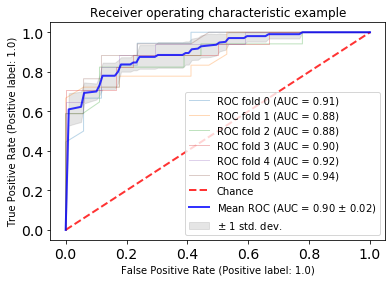

In [41]:
ROCValidation(clf_rfc,X_sel,y)

With features selection multilayer perceptron model improve over 40% in accuracy. These results suggest that neural networks are very sensivitive to the selected input features

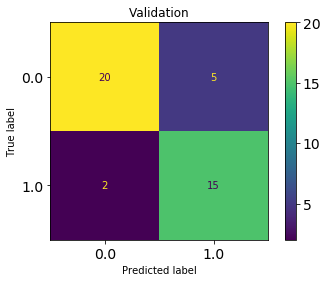

MULTILAYER PERCEPTRON
Sklearn Accuracy:  83.33333333333334  %
Sklearn Precision:  75.0  %
Sklearn Recall:  88.23529411764706  %
Sensitivity - Recall (true positive rate):  0.8823529411764706
Specificity:  0.8
Accuracy:  0.8333333333333334
Precision:  0.75
F1-Score:  0.8108108108108107
False positive rate:  0.2
Error:  0.16666666666666666
               precision    recall  f1-score   support

Right otolith       0.91      0.80      0.85        25
 Left otolith       0.75      0.88      0.81        17

     accuracy                           0.83        42
    macro avg       0.83      0.84      0.83        42
 weighted avg       0.84      0.83      0.83        42



In [42]:
# multilayer perceptron results
validationResult(clf_mlp,"MULTILAYER PERCEPTRON",y_test,mlp_prediction)

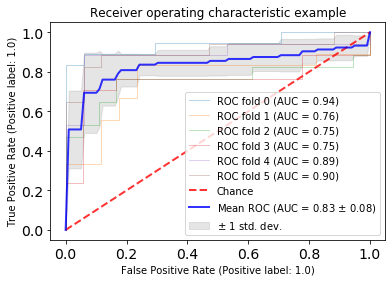

In [43]:
ROCValidation(clf_mlp,X_sel,y)